<center>

<a href="http://www.insa-toulouse.fr/" ><img src="logo-insa.png" style="float:left; max-width: 250px; display: inline" alt="INSA"/></a>

<a href="http://onera.fr/" ><img src="logo-onera.png" style="float:right; max-width: 250px; display: inline" alt="ONERA"/></a>

</center>

# **Table of contents**

The notebook is followed by this procedure:

- [1. Load the libraries and dataset](): 
  - Load the necessary libraries and our excel dataset `DeLiAn`.
  - Rename the sheets in a more meaningful way.
- [2. Data Preprocessing and Exploratory Data Analysis](): 
  - Select the interessed sheets and convert them into a dataframe.
  - Visualize to better understand the data.
  - Impute the missing values and check the quality of `df_imputed`.
  - Generate the new data from `df_imputed` to create the dataframe `df_generated`.
  - Calculate the others intensive optical properties from `df_generated` to create the dataframe `df_extended`.
  - Reduce the dimensions of `df_extended` with PCA to create the dataframe `df_pca`.
- [3. Build the classification models]():
  - Train-test split of each dataframe and standardize the data.
  - Create the function `select_model` to select the best hyperparameters of a type of model and perform the classification on a given dataframe.
  - Perform the classification on every dataframe with selected Machine Learning methods.
  - Select the variables (properties) and check that which properties are appropriate for which aerosols.
- [4. Conclusion]()

# **1. Load the libraries and dataset**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style='darkgrid', palette='colorblind')
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline

We have already rearranged the sheets of `DeLiAn` in a proper order (an intensive optical property followed by its errors) to create the new excel file `DeLiAn_edited`.

In [2]:
path    = 'data/'  # If data in 'data' directory
delian = pd.read_excel(path + 'DeLiAn_edited.xlsx', sheet_name=None) 

Now delian is a dictionary where **each key is the sheet name** and **each value is the corresponding DataFrame**.

In [3]:
for sheet_name in delian.keys():
    print(f"Sheet Name: {sheet_name}")
    print("----------------------------------------------------------------")

Sheet Name: List of variables
----------------------------------------------------------------
Sheet Name: 1
----------------------------------------------------------------
Sheet Name: 6
----------------------------------------------------------------
Sheet Name: 2
----------------------------------------------------------------
Sheet Name: 7
----------------------------------------------------------------
Sheet Name: 3
----------------------------------------------------------------
Sheet Name: 8
----------------------------------------------------------------
Sheet Name: 13
----------------------------------------------------------------
Sheet Name: 9
----------------------------------------------------------------
Sheet Name: 14
----------------------------------------------------------------
Sheet Name: 10
----------------------------------------------------------------
Sheet Name: 18
----------------------------------------------------------------
Sheet Name: 11
-----------------

Names of the sheets (except the sheet `List of variables`) are difficult to understand, because they are all hidden. Thus, we rename the sheets based on the sheet `List of variables`.

In [4]:
delian['List of variables']

,Sheet,Variables (unit),Description
0,1,angstrom_exponent_backscatter_355_532 (1),Angstrom exponent at 355/532 nm backscatter-re...
1,2,angstrom_exponent_backscatter_532_1064 (1),Angstrom exponent at 532/1064 nm backscatter-r...
2,3,angstrom_exponent_extinction_355_532 (1),Angstrom exponent at 355/532 nm extinction-rel...
3,4,campaign_rv,Name of the campaign or of the research vessel
4,5,date,Date of the lidar observations (DD-MM-YYYY or ...
5,6,error_angstrom_exponent_backscatter_355_532 (1),Error of the angstrom exponent at 355/532 nm b...
6,7,error_angstrom_exponent_backscatter_532_1064 (1),Error of the angstrom exponent at 532/1064 nm ...
7,8,error_angstrom_exponent_extinction_355_532 (1),Error of the angstrom exponent at 355/532 nm e...
8,9,error_lidar_ratio_355 (sr),Error of the lidar ratio of the aerosol catego...
9,10,error_lidar_ratio_532 (sr),Error of the lidar ratio of the aerosol catego...


In [5]:
variable_names = delian['List of variables']
# Iterate through each sheet and rename them
for sheet_name in delian.keys():
    if sheet_name != 'List of variables':
        # Filter the rows based on the condition and selecting the 'Variables (unit)' column
        new_sheet_name = variable_names.loc[variable_names['Sheet'] == int(sheet_name), 'Variables (unit)'].values[0]
        delian[new_sheet_name] = delian.pop(sheet_name)
        
delian.keys()

dict_keys(['List of variables', 'angstrom_exponent_backscatter_355_532 (1)', 'error_angstrom_exponent_backscatter_355_532 (1)', 'angstrom_exponent_backscatter_532_1064 (1)', 'error_angstrom_exponent_backscatter_532_1064 (1)', 'angstrom_exponent_extinction_355_532 (1)', 'error_angstrom_exponent_extinction_355_532 (1)', 'lidar_ratio_355 (sr)', 'error_lidar_ratio_355 (sr)', 'lidar_ratio_532 (sr)', 'error_lidar_ratio_532 (sr)', 'particle_linear_depolarization_ratio_355 (%)', 'error_particle_linear_depolarization_ratio_355 (%)', 'particle_linear_depolarization_ratio_532 (%)', 'error_particle_linear_depolarization_ratio_532 (%)', 'number_samples (1)', 'campaign_rv', 'date', 'location', 'measurement_type', 'reference', 'system'])

# **2. Data Preprocessing and Exploratory Data Analysis**

## **2.1. Convert the dataset to a dataframe**

Firstly, because our dataset is in excel format with each sheet is a variable or an information, we need to select the sheets we are interested in (the 7 sheets about intensive optical properties and the sheet number of samples) and then convert them to a dataframe.

The sheet `number_samples (1)` show how many times each aerosol type has been sampled (measured) by Lidar.

In [6]:
samples = delian['number_samples (1)']
samples

,Ash,Saharan dust,Central Asian dust,Middle Eastern dust,Smoke,Stratospheric smoke,Dust and smoke,Pollution,Dust and pollution,Dried marine,Clean marine,Dust and marine,Central European background
0,4,30,23,4,71,8,25,42,15,7,52,21,14


We can define a new dataframe containing the label (type of aerosol) of all observations based on this sheet.

In [7]:
aerosol = []
for col in samples.columns:
  for i in range(int(samples[col].iloc[0])):
    aerosol.append(col)
aerosol = pd.DataFrame({"aerosol": aerosol})
aerosol['aerosol'] = aerosol['aerosol'].astype('category') #convert type from Object to Categorical
aerosol

,aerosol
0,Ash
1,Ash
2,Ash
3,Ash
4,Saharan dust
...,...
311,Central European background
312,Central European background
313,Central European background
314,Central European background


In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

aerosol_encoder = label_encoder.fit_transform(aerosol.values.flatten())

# Print the mapping of original labels to encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'Ash': 0,
 'Central Asian dust': 1,
 'Central European background ': 2,
 'Clean marine': 3,
 'Dried marine': 4,
 'Dust and marine': 5,
 'Dust and pollution': 6,
 'Dust and smoke': 7,
 'Middle Eastern dust': 8,
 'Pollution': 9,
 'Saharan dust': 10,
 'Smoke': 11,
 'Stratospheric smoke': 12}

We are interested in the sheets containing data about the intensive optical properties of aerosols.

In [9]:
quantitatives = [
    'angstrom_exponent_backscatter_355_532 (1)',
    'error_angstrom_exponent_backscatter_355_532 (1)',
    'angstrom_exponent_backscatter_532_1064 (1)',
    'error_angstrom_exponent_backscatter_532_1064 (1)',
    'angstrom_exponent_extinction_355_532 (1)',
    'error_angstrom_exponent_extinction_355_532 (1)',
    'lidar_ratio_355 (sr)',
    'error_lidar_ratio_355 (sr)',
    'lidar_ratio_532 (sr)',
    'error_lidar_ratio_532 (sr)',
    'particle_linear_depolarization_ratio_355 (%)',
    'error_particle_linear_depolarization_ratio_355 (%)',
    'particle_linear_depolarization_ratio_532 (%)',
    'error_particle_linear_depolarization_ratio_532 (%)'
]
delian = {key: delian[key] for key in quantitatives}

In [10]:
properties = [
    'angstrom_exponent_backscatter_355_532 (1)',
    'angstrom_exponent_backscatter_532_1064 (1)',
    'angstrom_exponent_extinction_355_532 (1)',
    'lidar_ratio_355 (sr)',
    'lidar_ratio_532 (sr)',
    'particle_linear_depolarization_ratio_355 (%)',
    'particle_linear_depolarization_ratio_532 (%)',
]

In [11]:
properties_errors = [
    'error_angstrom_exponent_backscatter_355_532 (1)',
    'error_angstrom_exponent_backscatter_532_1064 (1)',
    'error_angstrom_exponent_extinction_355_532 (1)',
    'error_lidar_ratio_355 (sr)',
    'error_lidar_ratio_532 (sr)',
    'error_particle_linear_depolarization_ratio_355 (%)',
    'error_particle_linear_depolarization_ratio_532 (%)'
]

We need to convert each data in a sheet (a variable) into a familiar form (a column in a dataframe). The following cell wil perform this mission.

In [12]:
delian_df = pd.DataFrame()

# Iterate through each sheet and extract information
for sheet_name, df in delian.items():
  new_values = []
  for col in df.columns:
    for value in df[col]:
      # Check if the value is not NaN
      if pd.notna(value):
        new_values.append(value)
  new_df = pd.DataFrame({sheet_name: new_values})
  delian_df = pd.concat([delian_df, new_df], axis=1)

delian_df = pd.concat([delian_df, aerosol], axis=1) #concatenate with the labels
delian_df

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%),aerosol
0,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,55.00,5.00,-9999.0,-9999.0,36.50,1.0,-9999.0,-9999.0,Ash
1,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,55.00,5.00,-9999.0,-9999.0,37.50,2.0,-9999.0,-9999.0,Ash
2,0.22,0.4,1.05,0.43,0.68,0.63,39.00,10.00,32.0,4.0,-9999.00,-9999.0,-9999.0,-9999.0,Ash
3,1.00,-9999.0,1.00,-9999.00,1.00,-9999.00,55.00,10.00,64.0,11.0,34.00,4.0,-9999.0,-9999.0,Ash
4,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,63.00,9.00,-9999.0,-9999.0,24.00,2.0,31.0,1.0,Saharan dust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,48.07,2.24,-9999.0,-9999.0,2.91,2.0,-9999.0,-9999.0,Central European background
312,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,58.02,7.59,-9999.0,-9999.0,3.76,2.0,-9999.0,-9999.0,Central European background
313,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,58.57,5.69,-9999.0,-9999.0,3.75,2.0,-9999.0,-9999.0,Central European background
314,-9999.00,-9999.0,-9999.00,-9999.00,-9999.00,-9999.00,60.56,3.41,-9999.0,-9999.0,3.91,2.0,-9999.0,-9999.0,Central European background


**Errors explanation** : In our database, we have two types of error values: `NaN` and `-9999.0`.

**Why do we have these two types of error values?**

- `-9999.0` means we have a sample, **but** the measured value on this sample is in error, or somes properties are not mesured on this sample. It is synonymous with missing values or NaN in other databases. This one is what we need to impute or drop (depending on the method).

- `NaN` means we don't have a sample at all (what we have to drop and we dropped in the previous cell). Because each aerosol has a different number of samples by LiDAR, in each sheet of the original Excel, each column (representing each aerosol) has different lengths. So the columns are padded  to have equal lengths.

In short, `NaN` means no sample, while `-9999.0` means an error value for a sample.

We can't have a negative value in the error columns. This step is needed for visualization.

In [13]:
for col in properties_errors:
    delian_df[col] = delian_df[col].abs()  # Convert values in the error columns to absolute values

delian_df.head()

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%),aerosol
0,-9999.00,9999.0,-9999.00,9999.00,-9999.00,9999.00,55.0,5.0,-9999.0,9999.0,36.5,1.0,-9999.0,9999.0,Ash
1,-9999.00,9999.0,-9999.00,9999.00,-9999.00,9999.00,55.0,5.0,-9999.0,9999.0,37.5,2.0,-9999.0,9999.0,Ash
2,0.22,0.4,1.05,0.43,0.68,0.63,39.0,10.0,32.0,4.0,-9999.0,9999.0,-9999.0,9999.0,Ash
3,1.00,9999.0,1.00,9999.00,1.00,9999.00,55.0,10.0,64.0,11.0,34.0,4.0,-9999.0,9999.0,Ash
4,-9999.00,9999.0,-9999.00,9999.00,-9999.00,9999.00,63.0,9.0,-9999.0,9999.0,24.0,2.0,31.0,1.0,Saharan dust


## **2.2. Visualization**

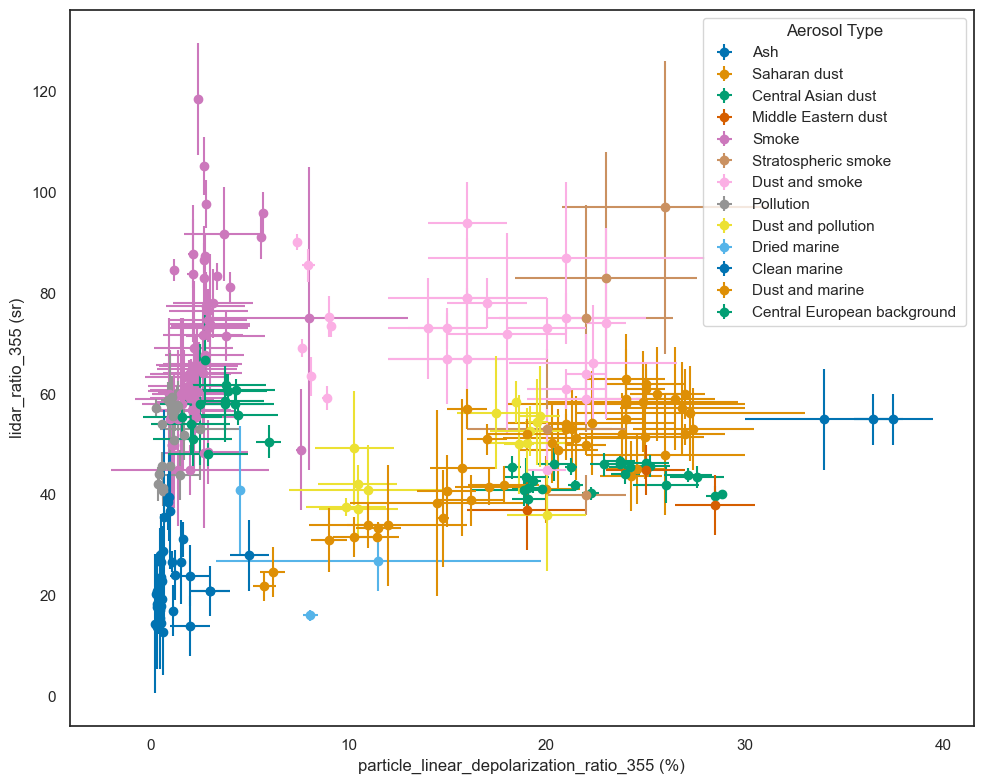

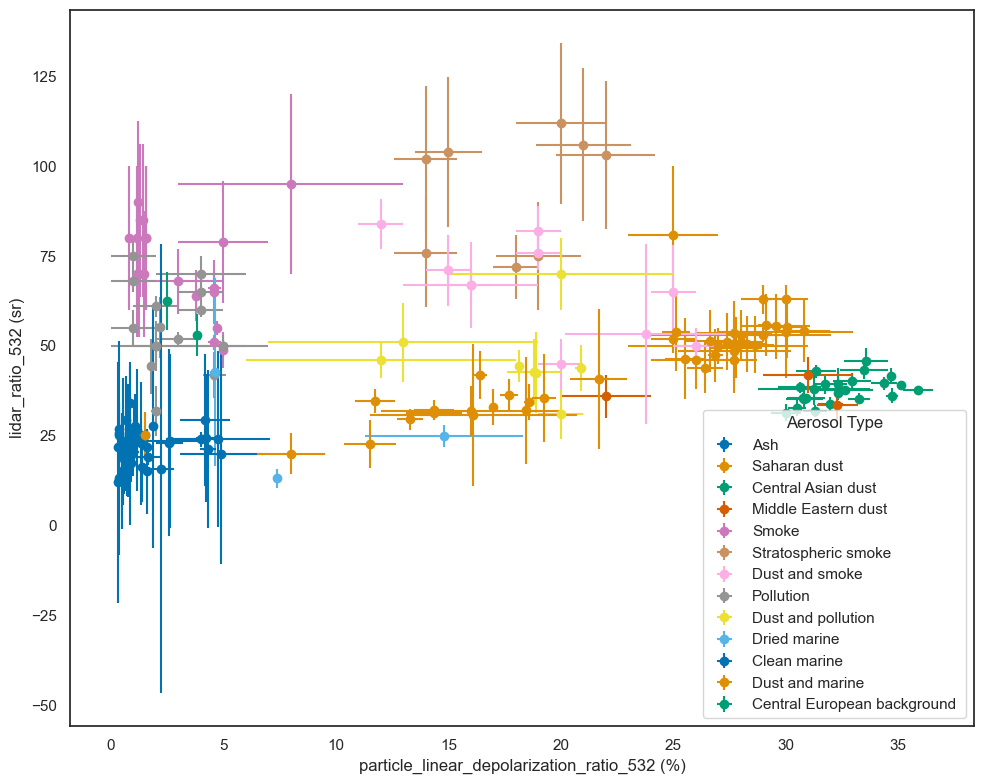

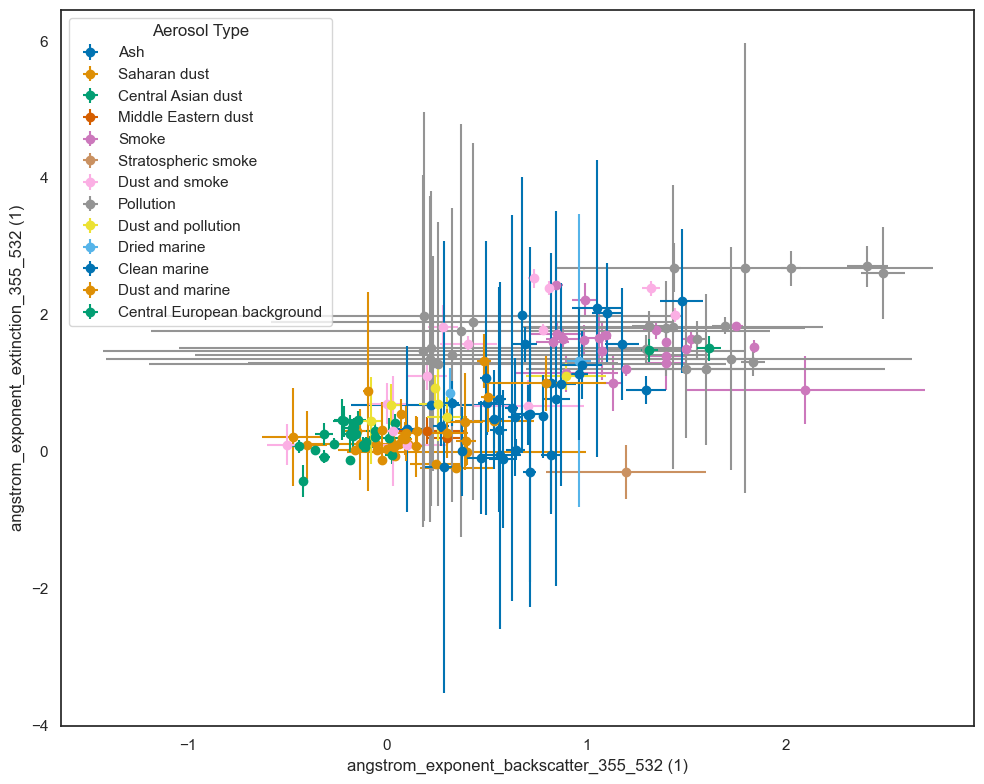

In [14]:
def visualize_with_error(df, x, y):
    plt.figure(figsize=(10, 8))
    sns.set_style("white")
    for aerosol_type in delian_df['aerosol'].unique():
        subset = df[delian_df['aerosol'] == aerosol_type]
        
        valid_subset = subset[(subset['error_' + x] != 9999) & 
                              (subset['error_' + y] != 9999)]
        
        plt.errorbar(valid_subset[x], valid_subset[y],
                    xerr=valid_subset['error_' + x], yerr=valid_subset['error_' + y],
                    fmt = "o", label=aerosol_type)
    
    plt.legend(title='Aerosol Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.tight_layout()
    plt.show()

visualize_with_error(delian_df, 'particle_linear_depolarization_ratio_355 (%)', 'lidar_ratio_355 (sr)')
visualize_with_error(delian_df, 'particle_linear_depolarization_ratio_532 (%)', 'lidar_ratio_532 (sr)')
visualize_with_error(delian_df, 'angstrom_exponent_backscatter_355_532 (1)', 'angstrom_exponent_extinction_355_532 (1)')

## **2.3. Data Imputation**

### **Impute with means**

We impute the error values of a column (variable), i.e. `-9999.0` equals the means (excepting `-9999.0`) of that variable. 

**Note:** we calculate the means and impute for each aerosol, using the `groupby` command.

In [15]:
def mean_without_9999(column):
    mean = column[abs(column) != 9999.].mean()
    return mean

def replace_9999(column):
    mean = mean_without_9999(column)
    column[abs(column) == 9999.] = mean
    return column

df = delian_df.groupby('aerosol', observed=True).transform(replace_9999)

df.head()

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%)
0,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,36.5,1.000000,NaN,NaN
1,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,37.5,2.000000,NaN,NaN
2,0.220000,0.400000,1.050000,0.430000,0.680000,0.63000,39.0,10.0,32.00000,4.000000,36.0,2.333333,NaN,NaN
3,1.000000,0.400000,1.000000,0.430000,1.000000,0.63000,55.0,10.0,64.00000,11.000000,34.0,4.000000,NaN,NaN
4,0.028737,0.109849,0.459035,0.117678,0.100489,0.17537,63.0,9.0,53.06897,7.863113,24.0,2.000000,31.0,1.0


The dataframe still have the value NaN in two columns `particle_linear_depolarization_ratio_532 (%)` and `error_particle_linear_depolarization_ratio_532 (%)`. That is because this optical property does not have any valid value for the `Ash` aerosol. So we will impute it as the mean of all measured values of all aerosols.

In [16]:
from sklearn.impute import SimpleImputer

# Create an imputer object to fill NaNs with the mean of each column
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer and transform the scaled data to fill in NaNs
df_imputed = imputer.fit_transform(df)

df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

df_imputed.head()

,angstrom_exponent_backscatter_355_532 (1),error_angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),error_angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),error_angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),error_lidar_ratio_355 (sr),lidar_ratio_532 (sr),error_lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),error_particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),error_particle_linear_depolarization_ratio_532 (%)
0,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,36.5,1.000000,10.883079,0.909911
1,0.610000,0.400000,1.025000,0.430000,0.840000,0.63000,55.0,5.0,48.00000,7.500000,37.5,2.000000,10.883079,0.909911
2,0.220000,0.400000,1.050000,0.430000,0.680000,0.63000,39.0,10.0,32.00000,4.000000,36.0,2.333333,10.883079,0.909911
3,1.000000,0.400000,1.000000,0.430000,1.000000,0.63000,55.0,10.0,64.00000,11.000000,34.0,4.000000,10.883079,0.909911
4,0.028737,0.109849,0.459035,0.117678,0.100489,0.17537,63.0,9.0,53.06897,7.863113,24.0,2.000000,31.000000,1.000000


### **Check the quality of the imputed data**

We only need to check the data duplication because the df_imputed have no null values.

In [17]:
df_imputed.duplicated().sum()

0

Attribute `dataframe.describe()` shows some basic information about the distribution of the data.

In [18]:
df_imputed.describe().T

,count,mean,std,min,25%,50%,75%,max
angstrom_exponent_backscatter_355_532 (1),316.0,0.779530,0.617844,-0.500000,0.272608,0.814661,1.365803,2.489430
error_angstrom_exponent_backscatter_355_532 (1),316.0,0.187158,0.268275,0.000214,0.047562,0.100000,0.183696,1.621820
angstrom_exponent_backscatter_532_1064 (1),316.0,0.799295,0.430504,-0.241943,0.491313,0.864506,1.166186,2.148480
error_angstrom_exponent_backscatter_532_1064 (1),316.0,0.168427,0.203761,0.000000,0.054529,0.109771,0.141246,1.151870
angstrom_exponent_extinction_355_532 (1),316.0,0.943316,0.692282,-0.428108,0.356404,0.932919,1.492750,2.706950
error_angstrom_exponent_extinction_355_532 (1),316.0,0.615900,0.651982,0.000501,0.177300,0.360162,0.820808,3.309086
lidar_ratio_355 (sr),316.0,50.673770,19.096687,12.821490,39.963554,51.113568,60.439445,118.548560
error_lidar_ratio_355 (sr),316.0,7.055542,5.290999,0.566400,3.323110,5.576068,9.000000,30.000000
lidar_ratio_532 (sr),316.0,49.166890,20.697239,12.063000,32.055051,48.000000,68.000000,112.000000
error_lidar_ratio_532 (sr),316.0,9.229730,6.964022,0.860434,4.563627,8.020870,11.135828,62.445038


We can visualize the distribution of each property of the imputed data to see if it is significantly right-skewed or left-skewed. If so, we need to normalize the data.

(*Overall, the properties are not significantly skewed in this case, so we don't need to normalize them.*)

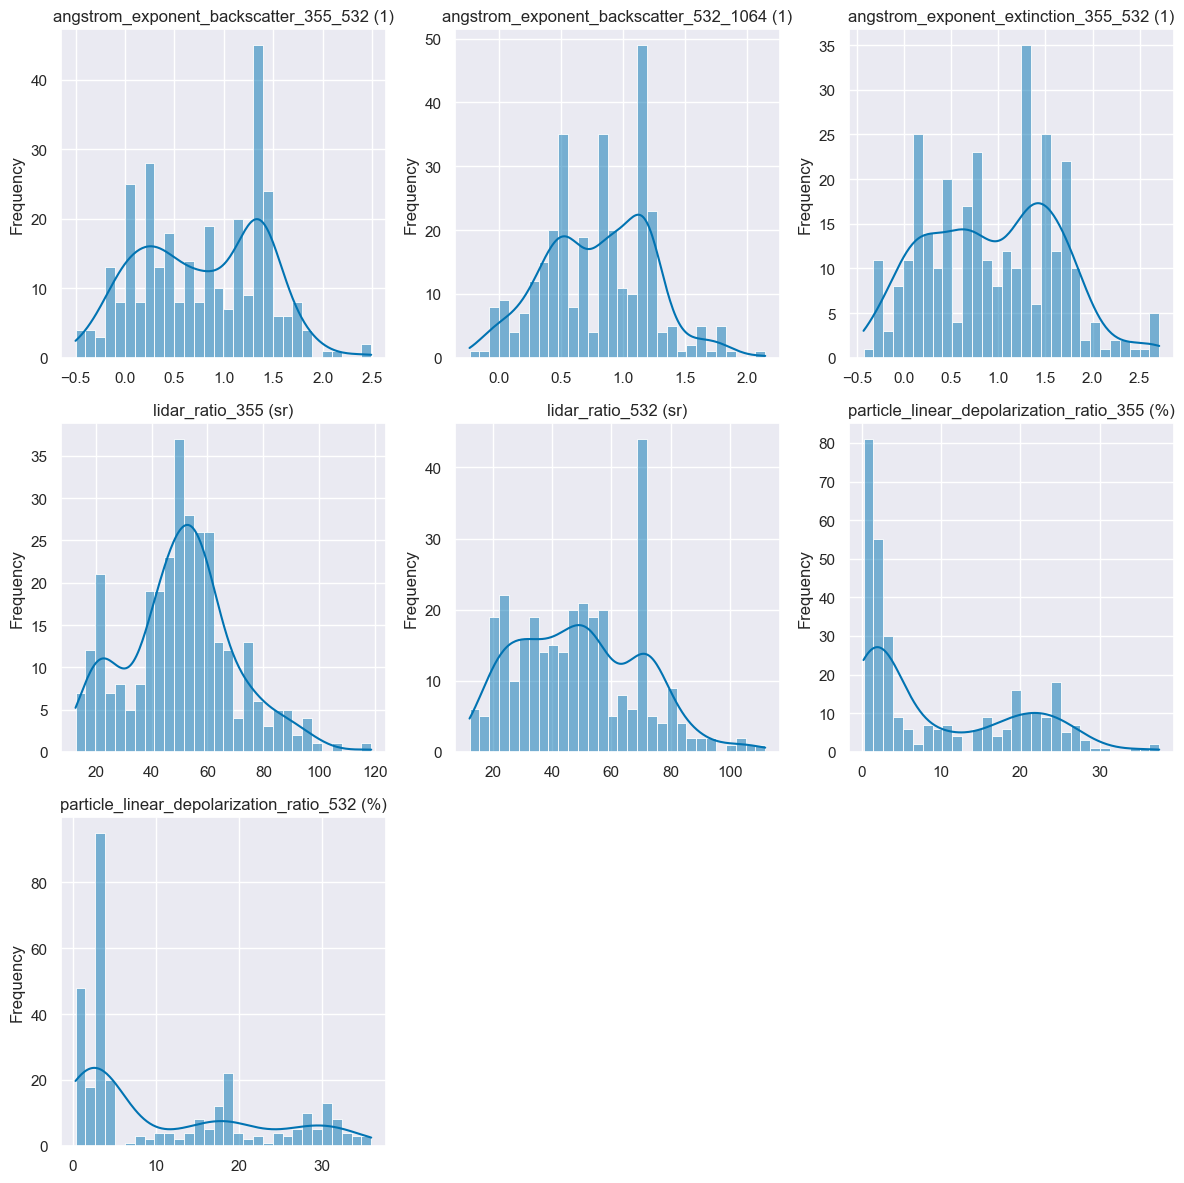

In [19]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i, column in enumerate(properties):
    sns.histplot(data=df_imputed[column], bins = 30, kde=True, ax=axes[i])  
    axes[i].set_title(f'{column}')  # Set title for the plot
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel(None)

# Adjust layoutcolumns)
axes[-1].set_visible(False)
axes[-2].set_visible(False)
plt.tight_layout()
plt.show()

Then, we detect the outliers of each property. If the outliers are too many, we can think about the replacement of the outliers. In this case, we don't need to remove the outliers.

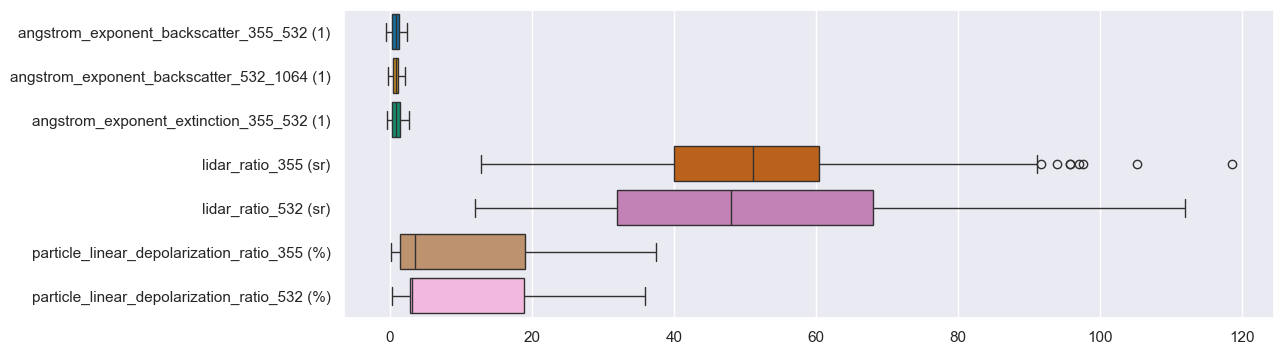

In [20]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_imputed[properties], orient='h')  # 'h' for horizontal boxplots

plt.show()

## **2.4. Data Augmentation** 
Generate new data based on the original data with the assumption that the properties follow the normal distributions.

**Why data augmentation is necessary?** Because the dataframe has been imputed so much data with the means. Although the `df_imputed` does not have any duplication in a view of all variables, it still have many duplicated data in a view of each variable. Therefore, data augmentation is necessary to give a more accurate result in the generalized errors.

In [21]:
def generate_samples(individual_data, n_samples=10):
    np.random.seed(28)
    means_columns = properties
    errors_columns = properties_errors
    
    means = individual_data[means_columns].astype(float).values
    errors = individual_data[errors_columns].astype(float).values
    
    generated_list = [individual_data[means_columns].values]  # Include only the properties
    
    # Generate new samples
    for _ in range(n_samples):
        # Generate random samples based on the mean and error values
        generated_values = np.random.normal(means, errors)
        generated_list.append(generated_values)
    
    generated_df = pd.DataFrame(generated_list, columns=means_columns)
    
    return generated_df

In [22]:
# Initialize a list to store DataFrames
generated_data = []

# Iterate over each row in the DataFrame
for index, row in df_imputed.iterrows():
    # Generate samples for the current row
    generated_df = generate_samples(row)
    # Append the DataFrame to the list without adding an index column
    generated_data.append(generated_df)

# Concatenate all DataFrames in the list into one DataFrame
df_generated = pd.concat(generated_data, ignore_index=True)

df_generated.head()

,angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%)
0,0.610000,1.025000,0.840000,55.000000,48.000000,36.500000,10.883079
1,0.788533,1.742722,0.673504,50.160825,48.443913,38.014620,11.189601
2,0.489053,0.664384,0.513829,56.267539,29.364720,35.848580,9.267559
3,0.703714,1.557942,0.430289,53.668925,43.959602,36.920741,10.796376
4,0.302050,0.945998,0.951390,58.685281,53.203970,35.684470,11.235833


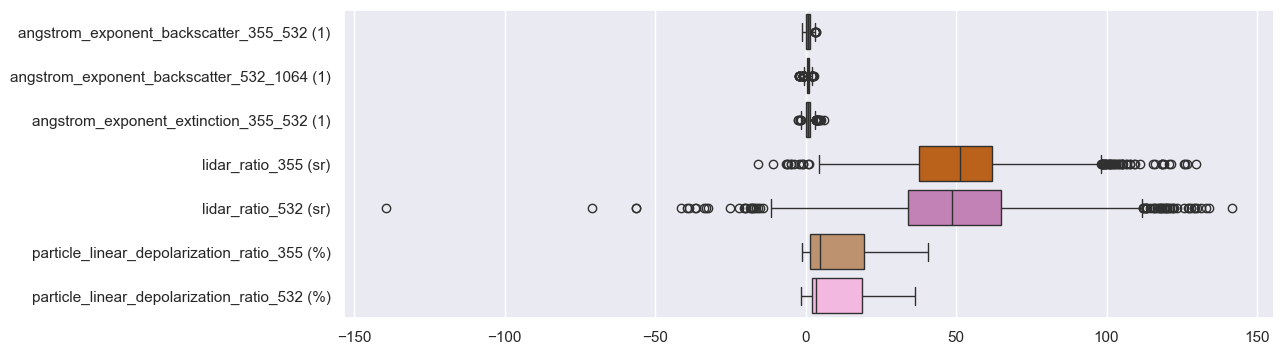

In [23]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_generated, orient='h')  # 'h' for horizontal boxplots

plt.show()

In [24]:
#Define a new df containing the label (type of aerosol) of the df_generated
aerosol_generated = []

for col in samples.columns:
  for i in range(int(samples[col].iloc[0]) * 11):
    aerosol_generated.append(col)
    
aerosol_generated = pd.DataFrame({"aerosol": aerosol_generated})

aerosol_generated['aerosol'] = aerosol_generated['aerosol'].astype('category') #convert type from Object to Categorical

aerosol_generated

,aerosol
0,Ash
1,Ash
2,Ash
3,Ash
4,Ash
...,...
3471,Central European background
3472,Central European background
3473,Central European background
3474,Central European background


In [25]:
aerosol_generated_encoder = label_encoder.fit_transform(aerosol_generated.values.flatten())

## **2.5. Calculate other intensive optical properties**

The intensive properties which the database already has are `the extinction-related Ångström exponent (AE)`, `the backscatter-related Ångström exponent (BAE)`, and `the lidar ratio (LR)`. Based on these properties, we can calculate the others : `the ratio of the backscatter coefficients profiles (color ratios – CRs)`, and `the ratio of the lidar ratios (RLR)`. The formulas of each property are provided below, where $\lambda$ is the wavelength, $z$ is the height, $a$ is the aerosol extinction coefficient, and $b$ is the aerosol backscatter coefficient.

1. **AE Formula**:
   $$
   AE_{\lambda_1/\lambda_2}(z) = -\ln \left( \frac{a(\lambda_1, z)}{a(\lambda_2, z)} \right)
   $$

2. **BAE Formula**:
   $$
   BAE_{\lambda_1/\lambda_2}(z) = -\ln \left( \frac{b(\lambda_1, z)}{b(\lambda_2, z)} \right)
   $$

3. **LR Formula**:
   $$
   LR(\lambda, z) = \frac{a(\lambda, z)}{b(\lambda, z)}
   $$

4. **CR Formula**:
   $$
   CR_{\lambda_1/\lambda_2}(z) = \frac{b(\lambda_1, z)}{b(\lambda_2, z)}
   $$

5. **RLR Formula**:
   $$
   RLR_{\lambda_1/\lambda_2}(z) = \frac{LR(\lambda_1, z)}{LR(\lambda_2, z)}
   $$


In [26]:
df_extended = df_generated.copy()

df_extended['color_ratio_355_532 (1)'] = df_extended['angstrom_exponent_backscatter_355_532 (1)'].map(lambda x : np.exp(-x))
df_extended['color_ratio_532_1064 (1)'] = df_extended['angstrom_exponent_backscatter_532_1064 (1)'].map(lambda x : np.exp(-x))
df_extended['ratio_lidar_ratio_355_532 (1)'] = df_extended['lidar_ratio_355 (sr)'] / df_extended['lidar_ratio_532 (sr)']

properties_extended = properties + ['color_ratio_355_532 (1)', 'color_ratio_532_1064 (1)', 'ratio_lidar_ratio_355_532 (1)']
df_extended.head()

,angstrom_exponent_backscatter_355_532 (1),angstrom_exponent_backscatter_532_1064 (1),angstrom_exponent_extinction_355_532 (1),lidar_ratio_355 (sr),lidar_ratio_532 (sr),particle_linear_depolarization_ratio_355 (%),particle_linear_depolarization_ratio_532 (%),color_ratio_355_532 (1),color_ratio_532_1064 (1),ratio_lidar_ratio_355_532 (1)
0,0.610000,1.025000,0.840000,55.000000,48.000000,36.500000,10.883079,0.543351,0.358796,1.145833
1,0.788533,1.742722,0.673504,50.160825,48.443913,38.014620,11.189601,0.454511,0.175043,1.035441
2,0.489053,0.664384,0.513829,56.267539,29.364720,35.848580,9.267559,0.613207,0.514590,1.916161
3,0.703714,1.557942,0.430289,53.668925,43.959602,36.920741,10.796376,0.494744,0.210569,1.220869
4,0.302050,0.945998,0.951390,58.685281,53.203970,35.684470,11.235833,0.739301,0.388292,1.103024


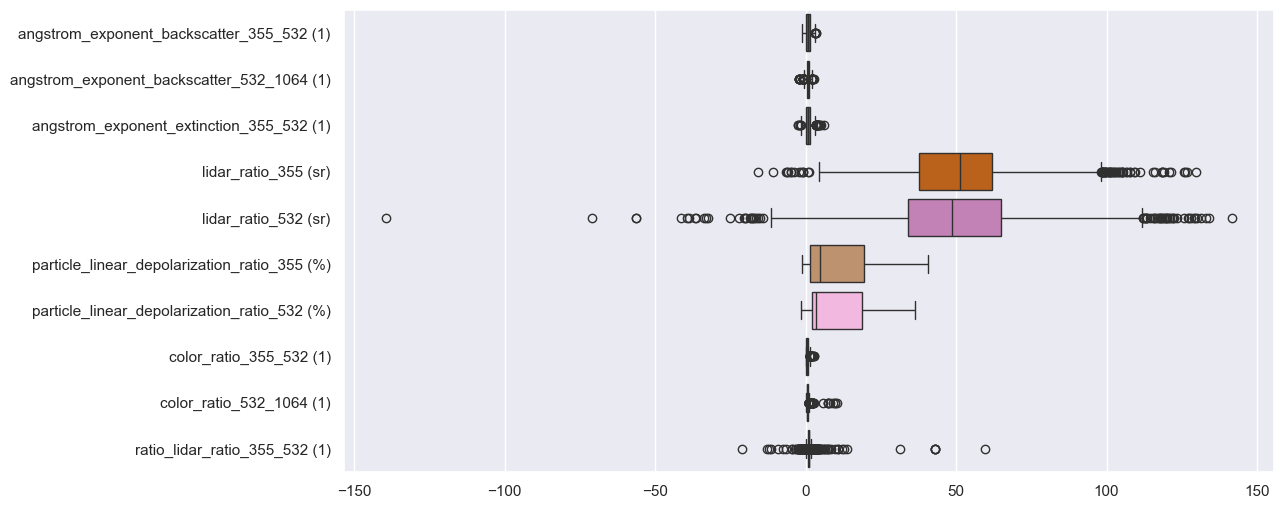

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_extended, orient='h')  # 'h' for horizontal boxplots

plt.show()

## **2.6. Principal Componants Analysis** 

Before performing the PCA, we need to standardize the data.

In [28]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
ss = StandardScaler()

# Fit and transform the data
df_scaled = ss.fit_transform(df_extended[properties_extended])

# Convert the scaled data back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns = properties_extended)

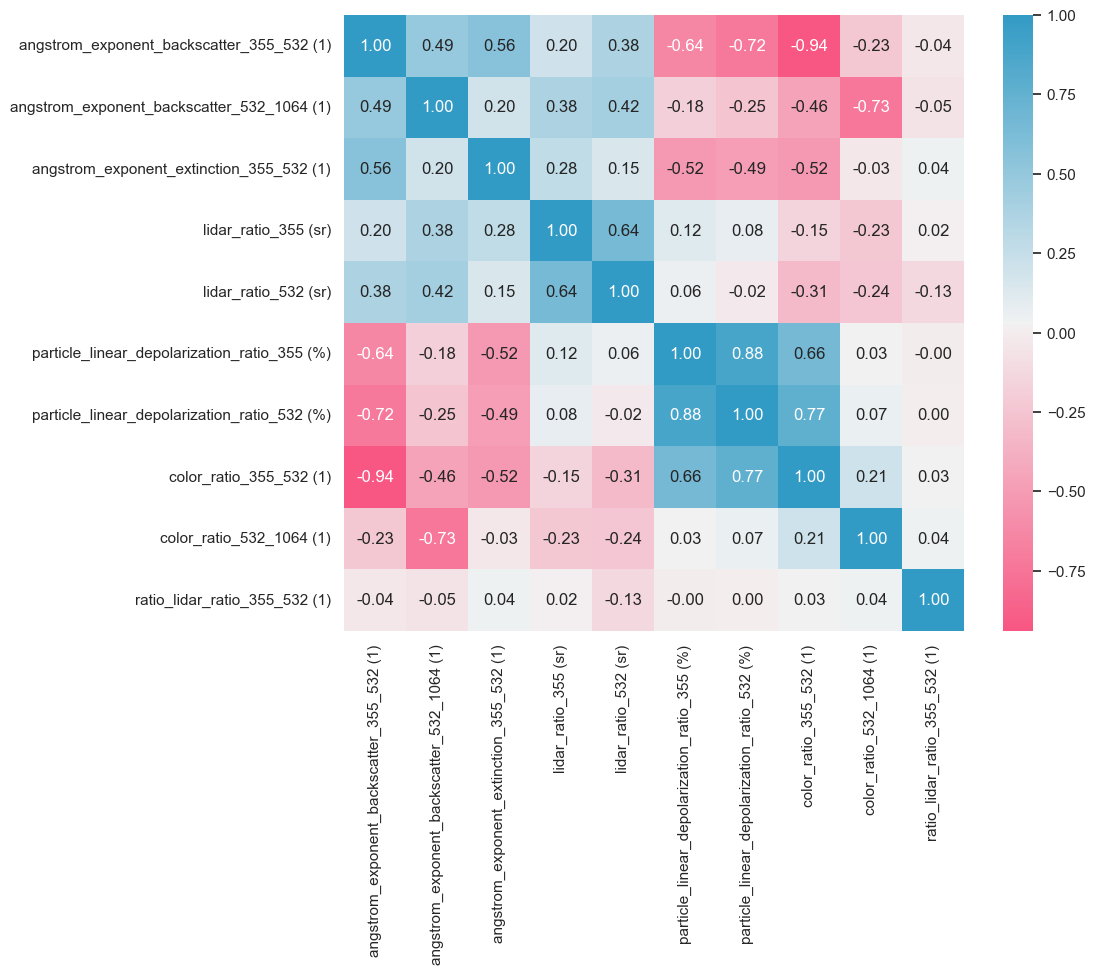

In [29]:
plt.figure(figsize=(10,8))
# correlation between columns
sns.heatmap(df_scaled.corr(), annot=True, fmt='.2f', cmap=cmap)
plt.xticks(rotation=90)

plt.show()

In [30]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
df_pca = pca.fit_transform(df_extended)

[ 67.481017    85.19211177  98.56157754  99.58243613  99.91718824
  99.95250977  99.98324043  99.99490521  99.99917973 100.        ]


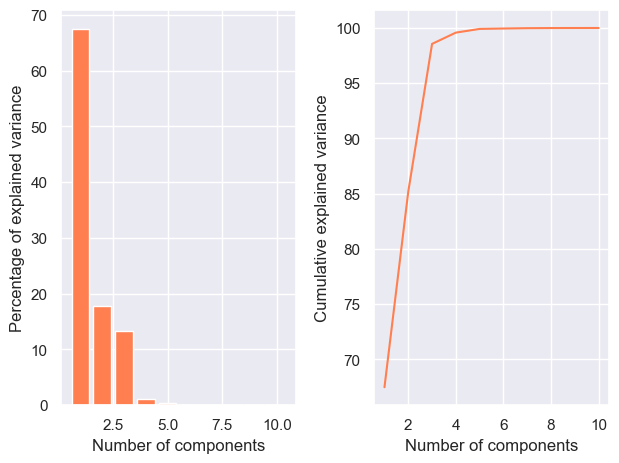

In [31]:
explained_variance_ratio = 100*pca.explained_variance_ratio_
print(np.cumsum(explained_variance_ratio))

plt.subplot(1,2,1)
n_bars = df_pca.shape[1]
plt.bar(np.arange(1, n_bars+1), explained_variance_ratio[:n_bars], color='coral')
plt.xlabel("Number of components")
plt.ylabel("Percentage of explained variance")

plt.subplot(1,2,2)
plt.plot(np.arange(1, n_bars+1), np.cumsum(explained_variance_ratio), color='coral')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

plt.tight_layout()
plt.show()

The first 3 components of the PCA contain moe than $98\%$ of the explained variance. So 3 seems to be the ideal number of chosen components. We verify this by plotting the boxplot.

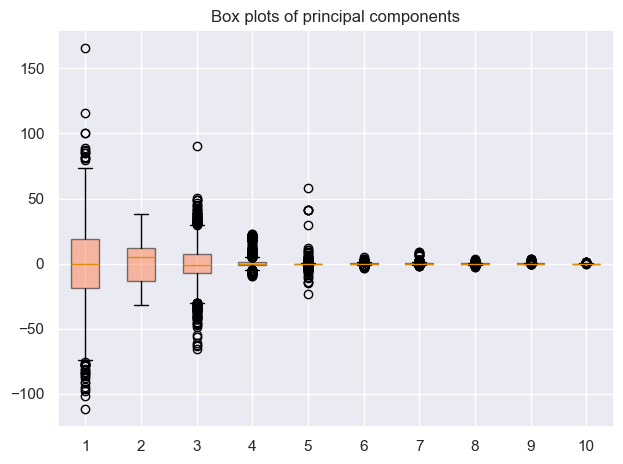

In [32]:
box = plt.boxplot(df_pca, patch_artist=True)
plt.setp(box["boxes"], facecolor="coral", alpha=.5)
plt.title("Box plots of principal components")
plt.tight_layout()
plt.show()

We can visualize the individual on PCA space.

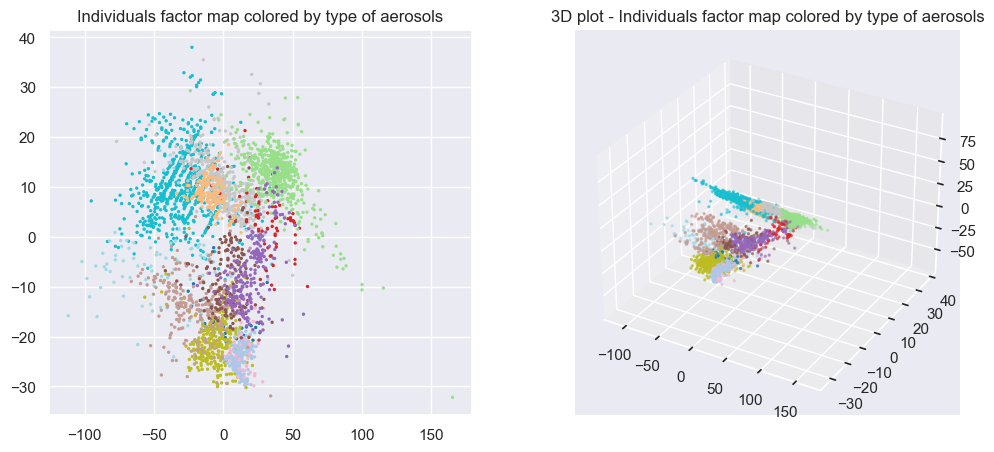

In [33]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.scatter(df_pca[:,0], df_pca[:,1], c=aerosol_generated_encoder, s=2, cmap='tab20')
ax.set_title("Individuals factor map colored by type of aerosols")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(df_pca[:,0], df_pca[:,1], df_pca[:,2], c=aerosol_generated_encoder, s=2, cmap='tab20')
ax.set_title("3D plot - Individuals factor map colored by type of aerosols")
plt.show()

In [34]:
df_pca_3 = df_pca[:,:3]

# **3. Build the predicted models**

Split the data set in a controlled manner to ensure the ratio between the training set and the test set is consistent for each class.

In [35]:
from sklearn.model_selection import train_test_split

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(df_imputed[properties], aerosol_encoder, test_size=0.25, stratify=aerosol_encoder, shuffle=True, random_state=28)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_generated, aerosol_generated_encoder, test_size=0.25, stratify=aerosol_generated_encoder, shuffle=True, random_state=28)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_extended, aerosol_generated_encoder, test_size=0.25, stratify=aerosol_generated_encoder, shuffle=True, random_state=28)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_pca_3, aerosol_generated_encoder, test_size=0.25, stratify=aerosol_generated_encoder, shuffle=True, random_state=28)

In [36]:
ss.fit(X_train_0)
X_train_0 = ss.transform(X_train_0)
X_test_0 = ss.transform(X_test_0)

ss.fit(X_train_1)
X_train_1 = ss.transform(X_train_1)
X_test_1 = ss.transform(X_test_1)

ss.fit(X_train_2)
X_train_2 = ss.transform(X_train_2)
X_test_2 = ss.transform(X_test_2)

ss.fit(X_train_3)
X_train_3 = ss.transform(X_train_3)
X_test_3 = ss.transform(X_test_3)

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Now we present the most important function that we use everywhere in the following parts of the notebook.

In [38]:
def selection_model(model, dataset, param_list, k_fold = 3, random_state = 28):
    """select the best hyperparameters for a type of model (kNN, SVM, etc) given a dataset (df, df_generated, df_pca, etc)

    Args:
        model (object of class): type of model that we use
        dataset (_type_): the dataset that we use to train and predict
        param_list (_type_): list of hyperparameters
        k_fold (int): number of folds of cross-validation
        random_state (int): to have the consistency results

    Returns:
        selection_model: best model with the selected hyperparameters
        
    Prints:
        Accuracy score on test set
        (Confusion matrix between the predicted and the true classes of test set)
        (Classification report on test set)
    """

    X_train, y_train, X_test, y_test = eval(f'(X_train_{dataset}, y_train_{dataset}, X_test_{dataset}, y_test_{dataset})')
    
    stratified_k_fold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=random_state) # Use the appropriate number of splits for the data
    
    # n_jobs=-1 means use all available CPU cores to speed up the search process.
    models=GridSearchCV(model,param_list,cv=stratified_k_fold,n_jobs=-1, verbose =2)

    #selected_model will be the optimized version of the models after the search by cross-validation.
    selected_model=models.fit(X_train, y_train)

    print("Best score = %f, Best parameter = %s" % (selected_model.best_score_,selected_model.best_params_))

    # Predict on the test set
    y_pred = selected_model.predict(X_test)

    # Evaluate the model
    print("Accuracy on test set:", accuracy_score(y_test, y_pred))
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred, zero_division=0))
    
    return selected_model

### **K-Nearest Neighbors**

#### Imputed dataframe

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knnOpt_0 = selection_model(KNeighborsClassifier(), dataset=0, param_list={'n_neighbors':list(range(2,20))})

Fitting 3 folds for each of 18 candidates, totalling 54 fits


Best score = 0.911392, Best parameter = {'n_neighbors': 2}
Accuracy on test set: 0.8607594936708861


#### Generated dataframe

In [40]:
knnOpt_1 = selection_model(KNeighborsClassifier(), dataset=1, param_list={'n_neighbors':list(range(2,20))})

Fitting 3 folds for each of 18 candidates, totalling 54 fits


Best score = 0.933257, Best parameter = {'n_neighbors': 3}
Accuracy on test set: 0.9551208285385501


#### Extended dataframe with other intensive optical properties

In [41]:
knnOpt_2 = selection_model(KNeighborsClassifier(), dataset=2, param_list={'n_neighbors':list(range(2,20))})

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best score = 0.930188, Best parameter = {'n_neighbors': 3}
Accuracy on test set: 0.9447640966628308


#### Dataframe with the first three components of PCA

In [42]:
knnOpt_3 = selection_model(KNeighborsClassifier(), dataset=3, param_list={'n_neighbors':list(range(2,20))})

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best score = 0.795550, Best parameter = {'n_neighbors': 5}
Accuracy on test set: 0.8193325661680092


### **Support Vector Machine (SVM)**

#### Imputed dataframe

In [43]:
from sklearn.svm import SVC
svmOpt_0 = selection_model(SVC(), dataset=0, param_list={'C':[0.001,0.01,0.1,1,10,100,1000]})

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best score = 0.915612, Best parameter = {'C': 10}
Accuracy on test set: 0.8354430379746836


#### Generated dataframe

In [44]:
svmOpt_1 = selection_model(SVC(), dataset=1, param_list={'C':[0.001,0.01,0.1,1,10,100,1000]})

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best score = 0.929421, Best parameter = {'C': 1000}
Accuracy on test set: 0.9378596087456847


#### Extended dataframe with other intensive optical properties

In [45]:
svmOpt_2 = selection_model(SVC(), dataset=2, param_list={'C':[0.001,0.01,0.1,1,10,100,1000]})

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best score = 0.928654, Best parameter = {'C': 1000}
Accuracy on test set: 0.9401611047180668


#### Dataframe with the first three components of PCA

In [46]:
svmOpt_3 = selection_model(SVC(), dataset=3, param_list={'C':[0.001,0.01,0.1,1,10,100,1000]})

Fitting 3 folds for each of 7 candidates, totalling 21 fits


Best score = 0.806674, Best parameter = {'C': 1000}
Accuracy on test set: 0.8135788262370541


### **Decision Tree**

#### Imputed dataframe

In [47]:
from sklearn.tree import DecisionTreeClassifier
treeOpt_0 = selection_model(DecisionTreeClassifier(random_state=28), dataset=0, param_list={"max_depth": [1, 2, 4, 8, 16, 32, 64, None]})

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score = 0.843882, Best parameter = {'max_depth': 8}
Accuracy on test set: 0.8354430379746836


#### Generated dataframe

In [48]:
treeOpt_1 = selection_model(DecisionTreeClassifier(random_state=28), dataset=1, param_list={"max_depth": [1, 2, 4, 8, 16, 32, 64, None]})

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score = 0.899501, Best parameter = {'max_depth': 16}
Accuracy on test set: 0.9401611047180668


#### Extended dataframe with other intensive optical properties

In [49]:
treeOpt_2 = selection_model(DecisionTreeClassifier(random_state=28), dataset=2, param_list={"max_depth": [1, 2, 4, 8, 16, 32, 64, None]})

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score = 0.903721, Best parameter = {'max_depth': 16}
Accuracy on test set: 0.9298043728423475


#### Dataframe with the first three components of PCA

In [50]:
treeOpt_3 = selection_model(DecisionTreeClassifier(random_state=28), dataset=3, param_list={"max_depth": [1, 2, 4, 8, 16, 32, 64, None]})

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score = 0.754891, Best parameter = {'max_depth': 8}
Accuracy on test set: 0.7733026467203682


### **Random Forest**

#### Imputed dataframe

In [51]:
from sklearn.ensemble import RandomForestClassifier

param=[{'n_estimators': [50, 100, 500],
        'max_features': [2, 3, 4],
        'max_depth' : [2, 4, 8, None]}]

rfOpt_0 = selection_model(RandomForestClassifier(random_state=28), dataset=0, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.940928, Best parameter = {'max_depth': None, 'max_features': 2, 'n_estimators': 50}
Accuracy on test set: 0.9240506329113924


particle_linear_depolarization_ratio_532 (%) 0.19066936465353074
lidar_ratio_355 (sr) 0.1833917186505712
lidar_ratio_532 (sr) 0.1817209569502559
particle_linear_depolarization_ratio_355 (%) 0.14480098885472564
angstrom_exponent_extinction_355_532 (1) 0.1032169128196597
angstrom_exponent_backscatter_355_532 (1) 0.10152582571524028
angstrom_exponent_backscatter_532_1064 (1) 0.09467423235601657


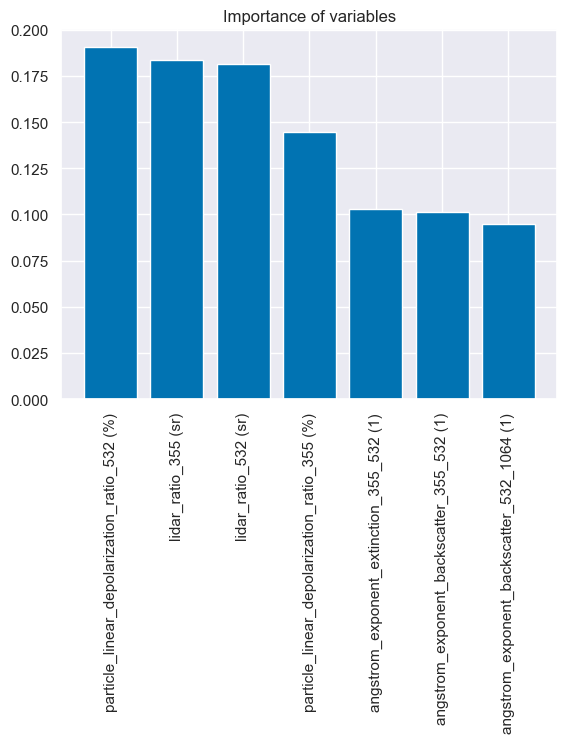

In [52]:
rf= rfOpt_0.best_estimator_

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(properties)):
    print(properties[indices[f]], importances[indices[f]])
    
sorted_importances = [properties[indices[f]] for f in range(len(properties))]

plt.figure()
plt.title("Importance of variables")
plt.bar(range(len(properties)), importances[indices])
plt.xticks(range(len(properties)), sorted_importances, rotation=90)
plt.show()

#### Generated dataframe

In [53]:
rfOpt_1 = selection_model(RandomForestClassifier(random_state=28), dataset=1, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.962025, Best parameter = {'max_depth': None, 'max_features': 2, 'n_estimators': 100}
Accuracy on test set: 0.9723820483314154


particle_linear_depolarization_ratio_532 (%) 0.21634434443353556
lidar_ratio_355 (sr) 0.18474835509811033
lidar_ratio_532 (sr) 0.14043167457646744
particle_linear_depolarization_ratio_355 (%) 0.13887201139165103
angstrom_exponent_backscatter_355_532 (1) 0.11644546057667363
angstrom_exponent_backscatter_532_1064 (1) 0.10800798863777553
angstrom_exponent_extinction_355_532 (1) 0.09515016528578656


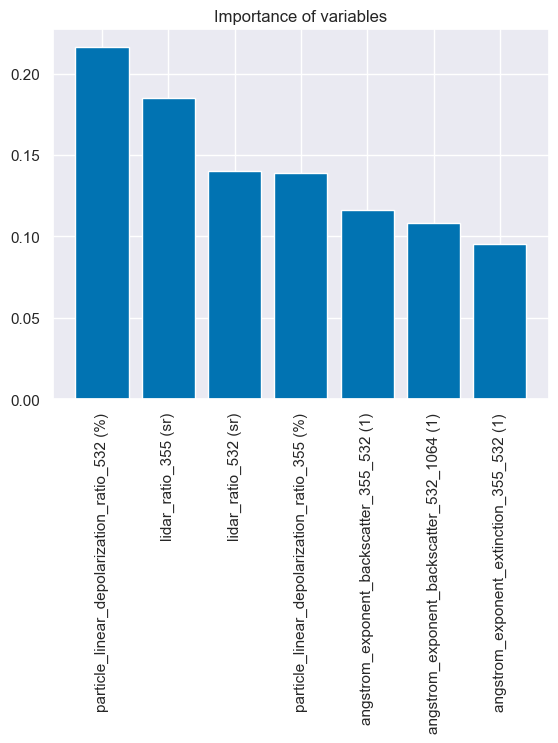

In [54]:
rf= rfOpt_1.best_estimator_

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(properties)):
    print(properties[indices[f]], importances[indices[f]])
    
sorted_importances = [properties[indices[f]] for f in range(len(properties))]

plt.figure()
plt.title("Importance of variables")
plt.bar(range(len(properties)), importances[indices])
plt.xticks(range(len(properties)), sorted_importances, rotation=90)
plt.show()

#### Extended dataframe with other intensive optical properties

In [55]:
rfOpt_2 = selection_model(RandomForestClassifier(random_state=28), dataset=2, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.962792, Best parameter = {'max_depth': None, 'max_features': 2, 'n_estimators': 500}
Accuracy on test set: 0.9746835443037974


particle_linear_depolarization_ratio_532 (%) 0.16876433905281008
lidar_ratio_355 (sr) 0.150322380646591
particle_linear_depolarization_ratio_355 (%) 0.12759557356883625
lidar_ratio_532 (sr) 0.11674503550900163
color_ratio_355_532 (1) 0.08790225584543475
angstrom_exponent_backscatter_355_532 (1) 0.08693077348532434
angstrom_exponent_extinction_355_532 (1) 0.08064700936213379
angstrom_exponent_backscatter_532_1064 (1) 0.07391017341278178
color_ratio_532_1064 (1) 0.07347024625201108
ratio_lidar_ratio_355_532 (1) 0.03371221286507523


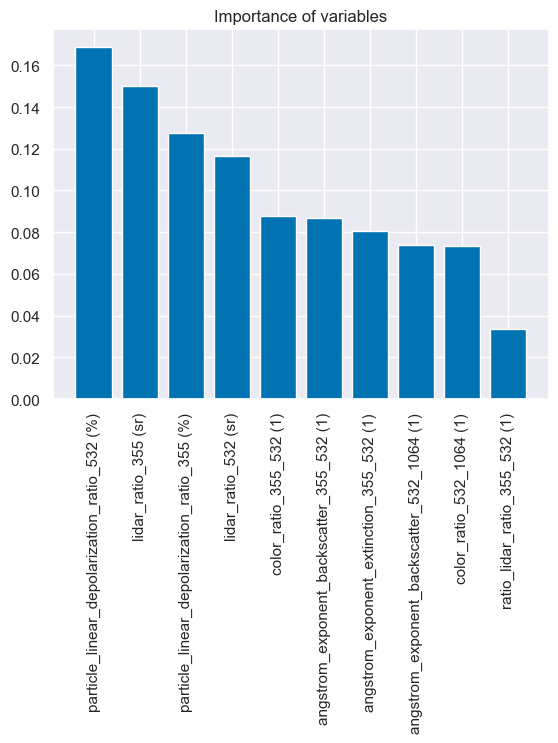

In [56]:
rf= rfOpt_2.best_estimator_

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(properties_extended)):
    print(properties_extended[indices[f]], importances[indices[f]])
    
sorted_importances = [properties_extended[indices[f]] for f in range(len(properties_extended))]

plt.figure()
plt.title("Importance of variables")
plt.bar(range(len(properties_extended)), importances[indices])
plt.xticks(range(len(properties_extended)), sorted_importances, rotation=90)
plt.show()

#### Dataframe with the first three components of PCA

In [57]:
rfOpt_3 = selection_model(RandomForestClassifier(random_state=28), dataset=3, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.802071, Best parameter = {'max_depth': None, 'max_features': 2, 'n_estimators': 500}
Accuracy on test set: 0.8377445339470656


### **Hist Gradient Boosting**

#### Imputed dataframe

In [58]:
from sklearn.ensemble import HistGradientBoostingClassifier

param = [{
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 8, None],
    'l2_regularization': [0, 0.1, 0.5]
}]

hgbOpt_0 = selection_model(HistGradientBoostingClassifier(random_state=28), dataset=0, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


  File "c:\Users\buimi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Best score = 0.928270, Best parameter = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 4}
Accuracy on test set: 0.9240506329113924


#### Generated dataframe

In [59]:
hgbOpt_1 = selection_model(HistGradientBoostingClassifier(random_state=28), dataset=1, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.970464, Best parameter = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': 8}
Accuracy on test set: 0.9735327963176065


#### Extended dataframe with other intensive optical properties

In [60]:
hgbOpt_2 = selection_model(HistGradientBoostingClassifier(random_state=28), dataset=2, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best score = 0.970848, Best parameter = {'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': None}
Accuracy on test set: 0.9700805523590333


#### Dataframe with the first three components of PCA

In [61]:
hgbOpt_3 = selection_model(HistGradientBoostingClassifier(random_state=28), dataset=3, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best score = 0.790180, Best parameter = {'l2_regularization': 0, 'learning_rate': 0.05, 'max_depth': 8}
Accuracy on test set: 0.8319907940161104


### **Extreme Gradient Boosting (XGBoost)**

#### Imputed dataframe

In [62]:
from xgboost import XGBClassifier

param = [{
    'n_estimators': [50, 100, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 8, None]
}]

xgbOpt_0 = selection_model(XGBClassifier(eval_metric='logloss', random_state=28), dataset=0, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.902954, Best parameter = {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Accuracy on test set: 0.9113924050632911


#### Generated dataframe

In [63]:
xgbOpt_1 = selection_model(XGBClassifier(eval_metric='logloss', random_state=28), dataset=1, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.964327, Best parameter = {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500}
Accuracy on test set: 0.9723820483314154


#### Extended dataframe with other intensive optical properties

In [64]:
xgbOpt_2 = selection_model(XGBClassifier(eval_metric='logloss', random_state=28), dataset=2, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best score = 0.965861, Best parameter = {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500}
Accuracy on test set: 0.9735327963176065


#### Dataframe with the first three components of PCA

In [65]:
xgbOpt_3 = selection_model(XGBClassifier(eval_metric='logloss', random_state=28), dataset=3, param_list=param)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Best score = 0.794783, Best parameter = {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500}
Accuracy on test set: 0.8296892980437284


### **Neural Network with TensorFlow**

In [79]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

def my_neural_network(dataset, random_state = 28):
    X_train, y_train, X_test, y_test = eval(f'(X_train_{dataset}, y_train_{dataset}, X_test_{dataset}, y_test_{dataset})')
    # Model configuration
    n_features = X_train.shape[1]
    n_classes = 13

    tf.random.set_seed(random_state)
    # Build the model
    model = Sequential([
        tf.keras.Input(shape=(n_features,)),
        Dense(128, activation='relu', name = "L1"),
        Dense(64, activation='relu', name = "L2"),
        Dense(n_classes, activation='linear', name = "L3")
    ])

    # Compile the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])

    history = model.fit(X_train, to_categorical(y_train), epochs=64, batch_size=32, validation_data = (X_test, to_categorical(y_test)))
    
    return history, model

In [80]:
history_0, nn_0 = my_neural_network(dataset = 0)

Epoch 1/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0250 - loss: 2.5867 - val_accuracy: 0.3165 - val_loss: 2.3983
Epoch 2/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4484 - loss: 2.2955 - val_accuracy: 0.5190 - val_loss: 2.1521
Epoch 3/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5838 - loss: 2.0448 - val_accuracy: 0.5316 - val_loss: 1.9104
Epoch 4/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5905 - loss: 1.7987 - val_accuracy: 0.5443 - val_loss: 1.6756
Epoch 5/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5863 - loss: 1.5656 - val_accuracy: 0.5823 - val_loss: 1.4740
Epoch 6/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5946 - loss: 1.3699 - val_accuracy: 0.6076 - val_loss: 1.3069
Epoch 7/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6424 - loss: 1.2141 - val_accuracy: 0.6203 - val_loss: 1.1694
Epoch 8/64
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6779 - loss: 1.0842 - val_accuracy: 0.6456 - val_loss: 1.0607
Epoch 9

In [81]:
history_1, nn_1 = my_neural_network(dataset = 1)

Epoch 1/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4276 - loss: 1.9482 - val_accuracy: 0.7215 - val_loss: 0.9127
Epoch 2/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.8367 - val_accuracy: 0.8009 - val_loss: 0.6212
Epoch 3/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7948 - loss: 0.6201 - val_accuracy: 0.8239 - val_loss: 0.5111
Epoch 4/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8199 - loss: 0.5298 - val_accuracy: 0.8470 - val_loss: 0.4540
Epoch 5/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8278 - loss: 0.4781 - val_accuracy: 0.8654 - val_loss: 0.4166
Epoch 6/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8402 - loss: 0.4416 - val_accuracy: 0.8780 - val_loss: 0.3901
Epoch 7/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8539 - loss: 0.4137 - val_accuracy: 0.8803 - val_loss: 0.3697
Epoch 8/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8579 - loss: 0.3919 - val_accuracy: 0.8792 - val_loss:

In [82]:
history_2, nn_2 = my_neural_network(dataset = 2)

Epoch 1/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4913 - loss: 1.9533 - val_accuracy: 0.7066 - val_loss: 0.9199
Epoch 2/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7242 - loss: 0.8455 - val_accuracy: 0.8032 - val_loss: 0.6217
Epoch 3/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7986 - loss: 0.6197 - val_accuracy: 0.8262 - val_loss: 0.5082
Epoch 4/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8280 - loss: 0.5233 - val_accuracy: 0.8516 - val_loss: 0.4516
Epoch 5/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8457 - loss: 0.4688 - val_accuracy: 0.8550 - val_loss: 0.4157
Epoch 6/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.4322 - val_accuracy: 0.8688 - val_loss: 0.3893
Epoch 7/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8628 - loss: 0.4013 - val_accuracy: 0.8746 - val_loss: 0.3697
Epoch 8/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.3765 - val_accuracy: 0.8780 - val_loss:

In [83]:
history_3, nn_3 = my_neural_network(dataset = 3)

Epoch 1/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4144 - loss: 2.0710 - val_accuracy: 0.6410 - val_loss: 1.1125
Epoch 2/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6831 - loss: 1.0151 - val_accuracy: 0.7468 - val_loss: 0.8309
Epoch 3/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7474 - loss: 0.8161 - val_accuracy: 0.7572 - val_loss: 0.7447
Epoch 4/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7649 - loss: 0.7421 - val_accuracy: 0.7606 - val_loss: 0.7001
Epoch 5/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7675 - loss: 0.6996 - val_accuracy: 0.7664 - val_loss: 0.6713
Epoch 6/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7654 - loss: 0.6696 - val_accuracy: 0.7675 - val_loss: 0.6494
Epoch 7/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7743 - loss: 0.6469 - val_accuracy: 0.7675 - val_loss: 0.6318
Epoch 8/64
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.6281 - val_accuracy: 0.7733 - val_loss:

Text(0.5, 1.0, 'Accuracy')

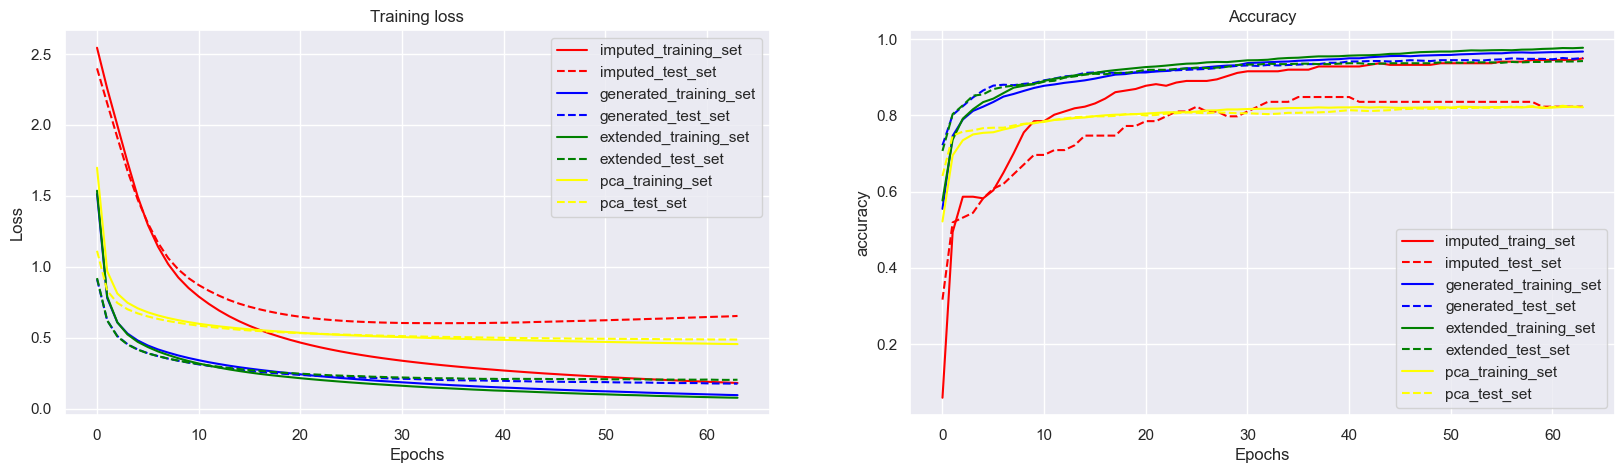

In [84]:
# %load solutions/compare_loss_acc.py
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
ax.plot(history_0.history["loss"], label="imputed_training_set", color="red")
ax.plot(history_0.history["val_loss"], label="imputed_test_set", linestyle="dashed" ,color="red")
ax.plot(history_1.history["loss"], label="generated_training_set", color="blue")
ax.plot(history_1.history["val_loss"], label="generated_test_set", linestyle="dashed" ,color="blue")
ax.plot(history_2.history["loss"], label="extended_training_set", color="green")
ax.plot(history_2.history["val_loss"], label="extended_test_set", linestyle="dashed" ,color="green")
ax.plot(history_3.history["loss"], label="pca_training_set", color="yellow")
ax.plot(history_3.history["val_loss"], label="pca_test_set", linestyle="dashed" ,color="yellow")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training loss")
ax.legend(loc='best')


ax = fig.add_subplot(1,2,2)
ax.plot(history_0.history["accuracy"], label="imputed_traing_set", color="red")
ax.plot(history_0.history["val_accuracy"], label="imputed_test_set", linestyle="dashed" ,color="red")
ax.plot(history_1.history["accuracy"], label="generated_training_set", color="blue")
ax.plot(history_1.history["val_accuracy"], label="generated_test_set", linestyle="dashed" ,color="blue")
ax.plot(history_2.history["accuracy"], label="extended_training_set", color="green")
ax.plot(history_2.history["val_accuracy"], label="extended_test_set", linestyle="dashed" ,color="green")
ax.plot(history_3.history["accuracy"], label="pca_training_set", color="yellow")
ax.plot(history_3.history["val_accuracy"], label="pca_test_set", linestyle="dashed" ,color="yellow")
ax.set_ylabel("accuracy")
ax.set_xlabel("Epochs")
ax.legend(loc='best')
ax.set_title("Accuracy")